In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix


sns.set()

In [122]:
?DecisionTreeClassifier

In [143]:
def train_and_cv_models(X,y,nfolds=3,random_state=42,):
    
    RS = random_state
    kf = KFold(n_splits=nfolds,shuffle=True,random_state=RS)
    
    print('Training XGB')

    model_xgb = XGBClassifier(random_state=RS,n_jobs=-1)
    grid_search_xgb = GridSearchCV(estimator=model_xgb,
                              param_grid = {'max_depth':[3,5,7],
                                           'n_estimators':[100,250],
                                           },
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=3,return_train_score=True)

    grid_search_xgb.fit(X,y)
    
    print('Training RandomForest')

    model_rf = RandomForestClassifier(random_state=RS,n_jobs=-1)
    grid_search_rf = GridSearchCV(estimator=model_rf,
                              param_grid = {'n_estimators':[50,100],
                                           'max_depth':[3,5,7]},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=3,return_train_score=True)

    grid_search_rf.fit(X,y)
    
    
    
    
    print('Training DecisionTree')

    model_dt = DecisionTreeClassifier(random_state=RS)
    grid_search_dt = GridSearchCV(estimator=model_dt,
                              param_grid = {'criterion':['gini','entropy']
                                           ,'max_depth':[50,75,100]},
                              scoring='accuracy',
                              cv=kf,
                              n_jobs=-1,
                              verbose=3,return_train_score=True)

    grid_search_dt.fit(X,y)
    
    
    
    print('Trained all models')
    
    model_dict = {
              'XGB':grid_search_xgb,
              'RF':grid_search_rf,   
              'DT':grid_search_dt}
    
    return model_dict

def eval_func(actual,prediction,roc=False,thresh=0.5):
    
    
    if roc:
        
        fpr, tpr, thresholds = roc_curve(actual, prediction)
        roc_auc = auc(tpr, fpr)

        
    prediction = prediction <= thresh
    prediction = prediction.astype(np.int)
        
    print('Accuracy = ',100*accuracy_score(actual,prediction))
    print('Confusion Matrix :')
    print(confusion_matrix(actual,prediction)*100/len(actual))
    
    if roc:
        plt.figure()
        plt.plot(tpr, fpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
    pass

def extract_results_from_models(model_dict):
    cols = ['Model','TrainAccMean','TrainAccStd','CVAccMean','CVAccStd']
    res_df = pd.DataFrame(columns=cols)
    
    for model_name,model in model_dict.items():
        print(model_name)
        model_cv_df = pd.DataFrame(model.cv_results_)
        best_row = model_cv_df[model_cv_df.rank_test_score==1].iloc[0]
        train_acc_mean = float(best_row.mean_train_score)
        train_acc_std = float(best_row.std_train_score)
        cv_acc_mean = float(best_row.mean_test_score)
        cv_acc_std = float(best_row.std_test_score)
        
        
        model_metrics = {
               'Model':model_name,
               'TrainAccMean':train_acc_mean,
                'TrainAccStd':train_acc_std,
                'CVAccMean':cv_acc_mean,
                'CVAccStd':cv_acc_std
               }
        res_df = res_df.append(model_metrics,ignore_index=True)
        
    return res_df

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv',parse_dates = [0])

In [3]:
users = pd.read_csv('takehome_users.csv',encoding='latin',parse_dates = [1,5],infer_datetime_format=True)

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0


In [5]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 937.6+ KB


In [7]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [8]:
users[users.last_session_creation_time=='nan']

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,nan,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,nan,0,0,302,NaN
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,nan,0,0,130,9270.0
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,nan,0,0,175,NaN
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,nan,0,0,211,NaN
17,18,2013-08-24 00:26:46,Gregersen Celina,CelinaAGregersen@jourrapide.com,GUEST_INVITE,nan,0,0,2,3153.0
25,26,2013-07-28 00:53:32,Wexler Florian,FlorianWexler@jourrapide.com,ORG_INVITE,nan,0,0,56,11857.0
31,32,2013-04-17 16:21:30,Perez Timothy,TimothyJPerez@yahoo.com,PERSONAL_PROJECTS,nan,1,1,98,NaN
33,34,2014-02-03 20:55:18,Holm Sara,SaraMHolm@hotmail.com,ORG_INVITE,nan,0,0,33,3721.0
34,35,2013-08-01 10:55:26,Krueger Dieter,DieterKrueger@gustr.com,PERSONAL_PROJECTS,nan,0,0,59,NaN


In [9]:
pd.to_datetime(users.last_session_creation_time.min(),unit='s')

Timestamp('2012-05-31 08:20:06')

In [10]:
users.creation_time.min()

Timestamp('2012-05-31 00:43:27')

In [11]:
same_date_ind = users[users.last_session_creation_time!='nan'].creation_time == pd.to_datetime(users[users.last_session_creation_time!='nan'].last_session_creation_time,unit='s')

In [12]:
users[(users.last_session_creation_time!='nan') & (same_date_ind)].describe(include='all')

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,3027.000000,3027,3027,3027,3027,3027,3027.000000,3027.000000,3027.000000,1575.000000
unique,NaN,3027,2989,3025,5,3027,NaN,NaN,NaN,NaN
top,NaN,2014-04-07 12:05:40,Araujo Gabriela,UlrikeGerste@gmail.com,ORG_INVITE,1400550648,NaN,NaN,NaN,NaN
freq,NaN,1,3,2,1088,1,NaN,NaN,NaN,NaN
first,NaN,2012-05-31 08:20:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2014-05-30 23:59:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6076.318137,NaN,NaN,NaN,NaN,NaN,0.242815,0.146680,133.294351,5929.639365
std,3463.767647,NaN,NaN,NaN,NaN,NaN,0.428855,0.353845,124.690780,3423.703010
min,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,7.000000
25%,3072.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,20.000000,2986.000000


last_session_creation_time is missing values. I'll replace them with the creation_time value assuming that the last_session isnt created for some cases if its created for the first time.

In [13]:
d = users.creation_time

In [14]:
creation_time_sec = (d - pd.Timestamp('1970-01-01'))//pd.Timedelta('1s')

In [15]:
nan_ind = users.last_session_creation_time=='nan'

In [16]:
users.last_session_creation_time[nan_ind] = creation_time_sec[nan_ind]

C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
users['last_session_creation_time'] = pd.to_datetime(users.last_session_creation_time,unit='s')

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption.

In [18]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [19]:
engagement.describe(include='all')

,time_stamp,user_id,visited
count,207917,207917.000000,207917.0
unique,207220,NaN,NaN
top,2014-02-05 03:09:54,NaN,NaN
freq,2,NaN,NaN
first,2012-05-31 08:20:06,NaN,NaN
last,2014-06-06 14:58:50,NaN,NaN
mean,NaN,5913.314197,1.0
std,NaN,3394.941674,0.0
min,NaN,1.000000,1.0
25%,NaN,3087.000000,1.0


In [20]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [21]:
engagement[engagement.time_stamp==('2014-02-05 03:09:54')]

,time_stamp,user_id,visited
162122,2014-02-05 03:09:54,9322,1
171651,2014-02-05 03:09:54,9691,1


In [22]:
visit_counts=pd.pivot_table(engagement, values='visited', index=['user_id', 'time_stamp'])

In [23]:
visit_counts.head()

visited
user_id time_stamp                  
1       2014-04-22 03:53:30        1
2       2013-11-15 03:45:04        1
        2013-11-29 03:45:04        1
        2013-12-09 03:45:04        1
        2013-12-25 03:45:04        1

In [24]:
visit_counts.describe()

,visited
count,207917.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [25]:
level_values = visit_counts.index.get_level_values
temp = (visit_counts.groupby([level_values(i) for i in [0,1]] +[pd.Grouper(freq='1w', level=-1)])).count()

In [26]:
temp=temp.reset_index(level=1)
temp=temp.drop(['time_stamp'],axis=1)
temp=temp.reset_index()

In [27]:
temp.head()

,user_id,time_stamp,visited
0,1,2014-04-27,1
1,2,2013-11-17,1
2,2,2013-12-01,1
3,2,2013-12-15,1
4,2,2013-12-29,1


In [28]:
by_week=temp.groupby(['user_id','time_stamp']).sum()
by_week.reset_index(inplace=True)
by_user = by_week.groupby('user_id').max()
by_user.drop('time_stamp',axis=1,inplace=True)
by_user.reset_index(inplace=True)

In [30]:
by_user.head()

,user_id,visited
0,1,1
1,2,3
2,3,1
3,4,1
4,5,1


In [32]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [36]:
?pd.merge

In [37]:
users_adopted = pd.merge(users,by_user,how='left',left_on='object_id',right_on='user_id',copy=False)

In [38]:
users_adopted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
user_id                       8823 non-null float64
visited                       8823 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(4), object(3)
memory usage: 1.2+ MB


In [35]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [39]:
eng_users = set(engagement.user_id)

In [40]:
user_users = set(users.object_id)

In [43]:
len(user_users-eng_users)

3177

3177 users not present in the engagement table. We can fill a 0 value because they did not engage ever

In [58]:
users_adopted['visited'] = users_adopted['visited'].fillna(value=0)

In [61]:
users_adopted.visited.value_counts()

1.0    6820
0.0    3177
2.0     558
7.0     488
3.0     280
5.0     234
6.0     222
4.0     221
Name: visited, dtype: int64

In [63]:
users_adopted['adopted']=np.where(users_adopted.visited>=3,1,0)

In [65]:
users_adopted.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,visited,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0,1.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2.0,3.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,3.0,1.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,4.0,1.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5.0,1.0,0


In [67]:
users_adopted.adopted.value_counts()

0    10555
1     1445
Name: adopted, dtype: int64

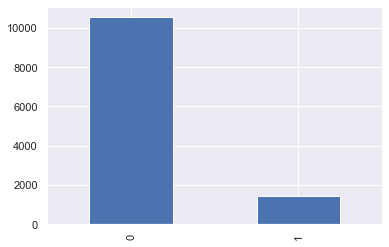

In [70]:
users_adopted.adopted.value_counts().plot(kind='bar');

We see a severe class imbalance here. Ideally we should treat it as an outlier detection problem.

For now i will use tree based methods to make the predicts since they are less sensitive to class imbalance. Methods that require normality of data would fail here.

In [82]:
data = users_adopted[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','adopted']]

In [83]:
data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,GUEST_INVITE,1,0,11,0
1,ORG_INVITE,0,0,1,1
2,ORG_INVITE,0,0,94,0
3,GUEST_INVITE,0,0,1,0
4,GUEST_INVITE,0,0,193,0


In [87]:
y=data['adopted']

In [88]:
data.drop('adopted',axis=1,inplace=True)

C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [89]:
X=pd.get_dummies(data,drop_first=True)

In [90]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,0,0,0,0
1,0,0,1,1,0,0,0
2,0,0,94,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,193,0,0,0,0


In [127]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [128]:
all_models=train_and_cv_models(X_train,y_train)

Training XGB
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:    5.4s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Training RandomForest
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:    1.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  18 | elapsed:    0.0s remaining:    0.0s


Training DecisionTree
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Trained all models


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


In [129]:
extract_results_from_models(all_models)

XGB
RF
DT


,Model,TrainAccMean,TrainAccStd,CVAccMean,CVAccStd
0,XGB,0.879635,0.001411,0.879271,0.002556
1,RF,0.879583,0.001479,0.879583,0.002957
2,DT,0.921510,0.002078,0.837396,0.005557


We can see that the RandomForest model performs that best on the cross validation set. Lets use the same model to predict the test set

In [206]:
preds = all_models['RF'].best_estimator_.predict(X_test)

In [208]:
print('accuracy = ',np.mean(y_test==preds)*100)

accuracy =  87.95833333333334


In [209]:
all_models['RF'].best_estimator_.feature_importances_

array([0.04085947, 0.01975674, 0.57671909, 0.02472408, 0.23959834,
       0.0281925 , 0.07014978])

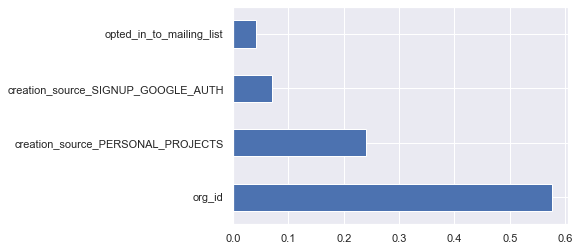

In [211]:
feat_importances = pd.Series(all_models['RF'].best_estimator_.feature_importances_, index=X_test.columns)
feat_importances.nlargest(4).plot(kind='barh');

In [ ]:
We can see that the the org_id,